# 🧠 BraTS 2020 Dataset: Exploratory Data Analysis

In [6]:
import os
import zipfile
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

## 📥 Data Acquisition

In [7]:
# Download dataset
!curl -L -o ~/Downloads/brats20-dataset-training-validation.zip \
https://www.kaggle.com/api/v1/datasets/download/awsaf49/brats20-dataset-training-validation

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4261M  100 4261M    0     0  31.7M      0  0:02:14  0:02:14 --:--:-- 31.6M


## 🔧 Data Preparation

In [8]:
# Unzip and Rename Files
zip_path = os.path.join(os.getcwd(), 'Downloads', 'brats20-dataset-training-validation.zip')
extract_dir = os.path.join(os.getcwd(), 'Data/')

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("✓ Unzipped successfully!")
else:
    print("✗ Zip file not found.")

✓ Unzipped successfully!


## 🛠️ Data Fixes

In [9]:
# Fix naming issue for patient 355
old_path = os.path.join(os.getcwd(), 'Data', 'BraTS2020_TrainingData', 'MICCAI_BraTS2020_TrainingData', 
                        'BraTS20_Training_355', 'W39_1998.09.19_Segm.nii')
folder = os.path.basename(os.path.dirname(old_path))
new_filename = f"{folder}_seg.nii"
new_path = os.path.join(os.path.dirname(old_path), new_filename)

if os.path.exists(old_path):
    os.rename(old_path, new_path)
    print(f"✓ Renamed to: {new_path}")
else:
    print("✓ Original file already renamed or does not exist.")

✓ Renamed to: /home/student01/Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii


## 🧩 Image Processing

In [10]:
print("\n" + "="*80)
print("PROCESSING ALL PATIENTS - GENERATING 3 IMAGE TYPES PER PATIENT")
print("="*80)

parent_dir = 'Data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
output_base = 'Data/Brats_slices'
os.makedirs(output_base, exist_ok=True)

# Get list of patient folders
patient_folders = sorted([f for f in os.listdir(parent_dir) if f.startswith('BraTS20_Training_')])
print(f"Found {len(patient_folders)} patients to process\n")

for idx, patient in enumerate(patient_folders, 1):
    base_path = os.path.join(parent_dir, patient, '')
    patient_output_dir = os.path.join(output_base, patient)
    os.makedirs(patient_output_dir, exist_ok=True)
    
    try:
        # Load all modalities
        t1ce_img = nib.load(base_path + f'{patient}_t1ce.nii')
        seg_img = nib.load(base_path + f'{patient}_seg.nii')
        
        t1ce_data = t1ce_img.get_fdata()
        seg_data = seg_img.get_fdata()
        
        # Find the slice with most tumor
        total_slices = t1ce_data.shape[2]
        tumor_counts = [np.sum(seg_data[:, :, i] > 0) for i in range(total_slices)]
        max_slice = np.argmax(tumor_counts)
        
        # ====================================================================
        # IMAGE TYPE 1: Single slice (most important)
        # ====================================================================
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        fig.suptitle(f'{patient} - Single Most Segmented Slice', fontsize=12, fontweight='bold')
        
        img = t1ce_data[:, :, max_slice]
        seg_slice = seg_data[:, :, max_slice]
        
        ax.imshow(img, cmap='gray')
        for lbl, color in [(1, 'red'), (2, 'green'), (4, 'blue')]:
            mask = seg_slice == lbl
            ax.imshow(mask, cmap=ListedColormap(['none', color]), alpha=0.5)
        
        ax.set_title(f'Slice {max_slice}')
        ax.axis('off')
        
        legend_elements = [
            plt.Rectangle((0,0),1,1, facecolor='red', alpha=0.5, label='NCR/NET'),
            plt.Rectangle((0,0),1,1, facecolor='green', alpha=0.5, label='ED'),
            plt.Rectangle((0,0),1,1, facecolor='blue', alpha=0.5, label='ET')
        ]
        fig.legend(handles=legend_elements, loc='lower center', fontsize='small', ncol=3, 
                  bbox_to_anchor=(0.5, -0.05))
        
        plt.tight_layout()
        fig.savefig(os.path.join(patient_output_dir, "single_slice.jpg"), bbox_inches='tight', dpi=150)
        plt.close(fig)
        
        # ====================================================================
        # IMAGE TYPE 2: 3 slices with jumps of 10
        # ====================================================================
        offsets = [-10, 0, 10]
        slices_3 = []
        for offset in offsets:
            idx_val = max_slice + offset
            if 0 <= idx_val < total_slices:
                slices_3.append(idx_val)
        
        # Pad if needed
        while len(slices_3) < 3:
            if slices_3[0] > 0:
                slices_3.insert(0, slices_3[0] - 1)
            elif slices_3[-1] < total_slices - 1:
                slices_3.append(slices_3[-1] + 1)
            else:
                break
        slices_3 = slices_3[:3]
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'{patient} - 3 Slices (Jump=10)', fontsize=12, fontweight='bold')
        
        for i, slice_idx in enumerate(slices_3):
            img = t1ce_data[:, :, slice_idx]
            seg_slice = seg_data[:, :, slice_idx]
            
            axes[i].imshow(img, cmap='gray')
            for lbl, color in [(1, 'red'), (2, 'green'), (4, 'blue')]:
                mask = seg_slice == lbl
                axes[i].imshow(mask, cmap=ListedColormap(['none', color]), alpha=0.5)
            
            axes[i].set_title(f'Slice {slice_idx}')
            axes[i].axis('off')
        
        fig.legend(handles=legend_elements, loc='lower center', fontsize='small', ncol=3, 
                  bbox_to_anchor=(0.5, -0.05))
        
        plt.tight_layout()
        fig.savefig(os.path.join(patient_output_dir, "three_slices.jpg"), bbox_inches='tight', dpi=150)
        plt.close(fig)
        
        # ====================================================================
        # IMAGE TYPE 3: 5 slices with jumps of 5
        # ====================================================================
        offsets = [-10, -5, 0, 5, 10]
        slices_5 = []
        for offset in offsets:
            idx_val = max_slice + offset
            if 0 <= idx_val < total_slices:
                slices_5.append(idx_val)
        
        # Pad if needed
        while len(slices_5) < 5:
            if slices_5[0] > 0:
                slices_5.insert(0, slices_5[0] - 1)
            elif slices_5[-1] < total_slices - 1:
                slices_5.append(slices_5[-1] + 1)
            else:
                break
        slices_5 = slices_5[:5]
        
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        fig.suptitle(f'{patient} - 5 Slices (Jump=5)', fontsize=12, fontweight='bold')
        
        for i, slice_idx in enumerate(slices_5):
            img = t1ce_data[:, :, slice_idx]
            seg_slice = seg_data[:, :, slice_idx]
            
            axes[i].imshow(img, cmap='gray')
            for lbl, color in [(1, 'red'), (2, 'green'), (4, 'blue')]:
                mask = seg_slice == lbl
                axes[i].imshow(mask, cmap=ListedColormap(['none', color]), alpha=0.5)
            
            axes[i].set_title(f'Slice {slice_idx}')
            axes[i].axis('off')
        
        fig.legend(handles=legend_elements, loc='lower center', fontsize='small', ncol=3, 
                  bbox_to_anchor=(0.5, -0.05))
        
        plt.tight_layout()
        fig.savefig(os.path.join(patient_output_dir, "five_slices.jpg"), bbox_inches='tight', dpi=150)
        plt.close(fig)
        
        print(f"[{idx}/{len(patient_folders)}] ✓ Processed {patient} - Generated 3 image types")
    
    except Exception as e:
        print(f"[{idx}/{len(patient_folders)}] ✗ Error processing {patient}: {e}")

print("\n" + "="*80)
print("ALL PATIENTS PROCESSED SUCCESSFULLY!")
print(f"Output directory: {output_base}")
print("="*80)


PROCESSING ALL PATIENTS - GENERATING 3 IMAGE TYPES PER PATIENT
Found 369 patients to process

[1/369] ✓ Processed BraTS20_Training_001 - Generated 3 image types
[2/369] ✓ Processed BraTS20_Training_002 - Generated 3 image types
[3/369] ✓ Processed BraTS20_Training_003 - Generated 3 image types
[4/369] ✓ Processed BraTS20_Training_004 - Generated 3 image types
[5/369] ✓ Processed BraTS20_Training_005 - Generated 3 image types
[6/369] ✓ Processed BraTS20_Training_006 - Generated 3 image types
[7/369] ✓ Processed BraTS20_Training_007 - Generated 3 image types
[8/369] ✓ Processed BraTS20_Training_008 - Generated 3 image types
[9/369] ✓ Processed BraTS20_Training_009 - Generated 3 image types
[10/369] ✓ Processed BraTS20_Training_010 - Generated 3 image types
[11/369] ✓ Processed BraTS20_Training_011 - Generated 3 image types
[12/369] ✓ Processed BraTS20_Training_012 - Generated 3 image types
[13/369] ✓ Processed BraTS20_Training_013 - Generated 3 image types
[14/369] ✓ Processed BraTS20_T

## 🖼️ Preview

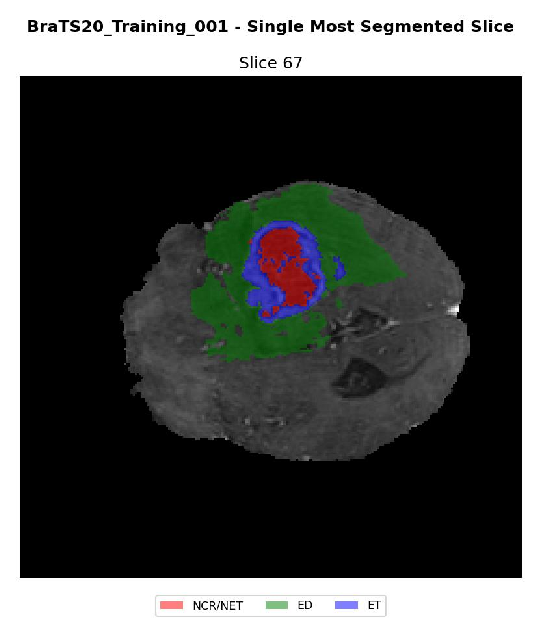

In [11]:
img_path = os.path.join("Data/Brats_slices", "BraTS20_Training_001", "single_slice.jpg")
if os.path.exists(img_path):
    img = plt.imread(img_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img, interpolation='none')
    plt.axis('off')
    plt.show()
else:
    print("Image not found:", img_path)

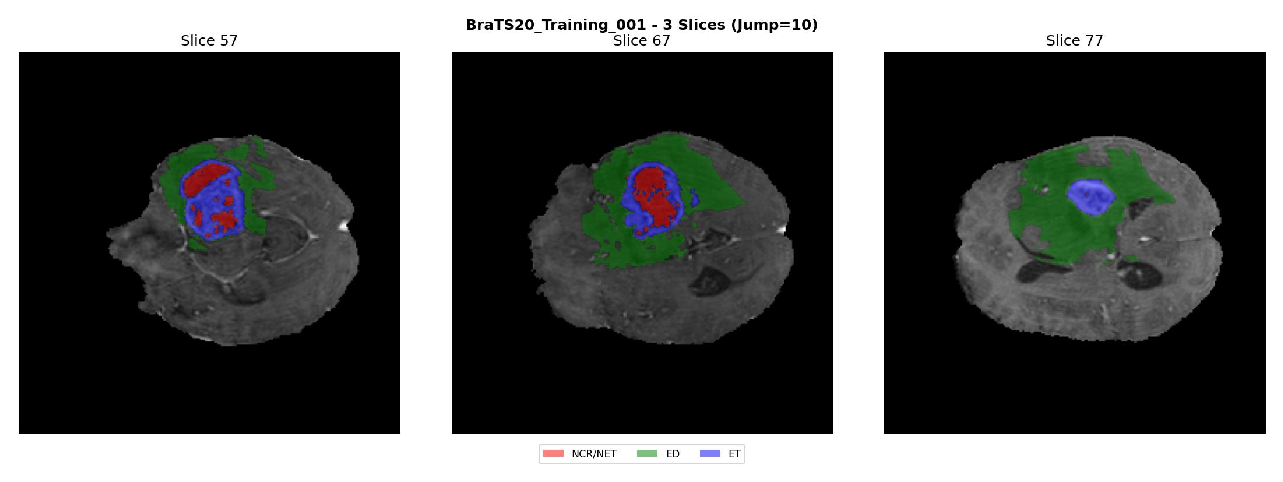

In [12]:
img_path = os.path.join("Data/Brats_slices", "BraTS20_Training_001", "three_slices.jpg")
if os.path.exists(img_path):
    img = plt.imread(img_path)
    plt.figure(figsize=(18, 6))
    plt.imshow(img, interpolation='none')
    plt.axis('off')
    plt.show()
else:
    print("Image not found:", img_path)

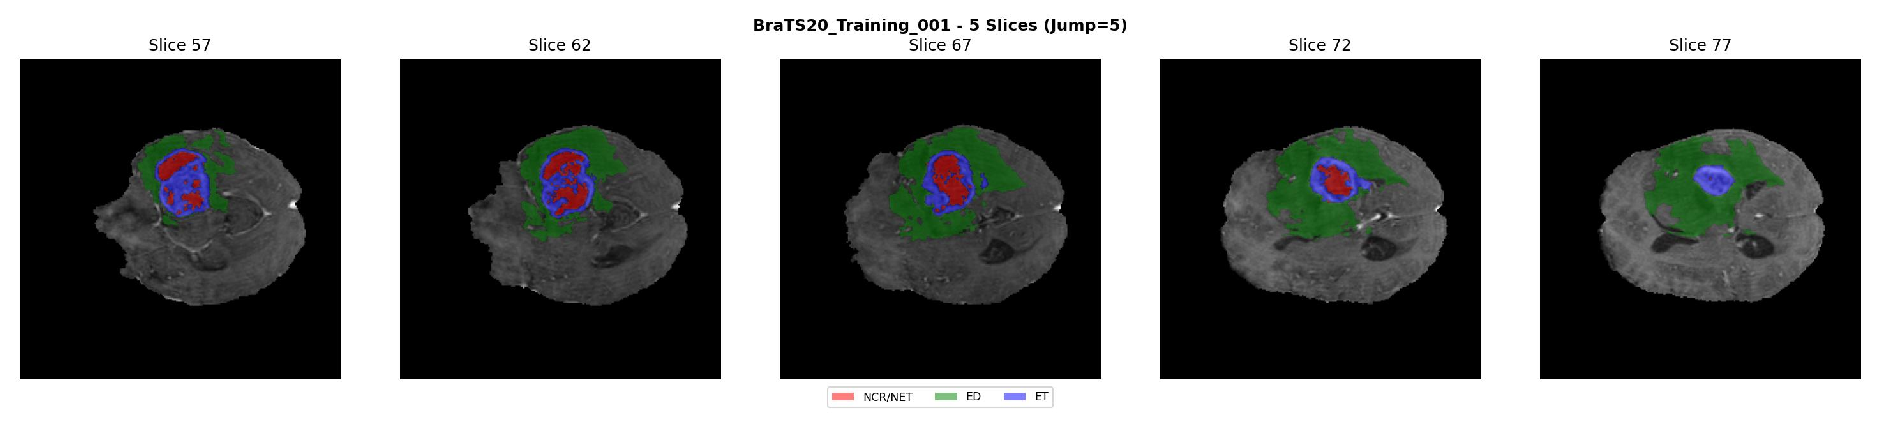

In [13]:
img_path = os.path.join("Data/Brats_slices", "BraTS20_Training_001", "five_slices.jpg")
if os.path.exists(img_path):
    img = plt.imread(img_path)
    plt.figure(figsize=(24, 6))
    plt.imshow(img, interpolation='none')
    plt.axis('off')
    plt.show()
else:
    print("Image not found:", img_path)